In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
%matplotlib inline

### Load dataset

In [2]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_output')
coords = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

THETA = ds_main.THETA.sel(face=[2,10])

In [3]:
# Budget terms
ds_budg = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/eccov4r3_budgets')
coords_budg = ds_budg.coords.to_dataset().reset_coords()
ds_budg = ds_budg.reset_coords(drop=True)

In [ ]:
# Anomaly budget
ds = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_datasets/anom/budgH/')

### Volume

In [5]:
# Volume (m^3)
vol = (coords.rA*coords.drF*coords.hFacC).transpose('face','k','j','i')

### Subselect data

In [6]:
# Define spatial boundaries of the SPNA
patch_lats = [46, 65, 65, 46]
patch_lons = [-95, -95, 10, 10]

In [7]:
ds = ds.where((coords.XC>=np.min(patch_lons))&(coords.XC<=np.max(patch_lons))&\
              (coords.YC>=np.min(patch_lats))&(coords.YC<=np.max(patch_lats))).isel(time=slice(1, -1))

In [8]:
vol = vol.where((coords.XC>=np.min(patch_lons))&(coords.XC<=np.max(patch_lons))&\
                (coords.YC>=np.min(patch_lats))&(coords.YC<=np.max(patch_lats)))

### Sum over entire SPNA

In [11]:
# Add vertical and horizontal components of advection and diffusion terms
ds['adv_Uanom_Tclim'] = ds.hadv_Uanom_Tclim+ds.vadv_Uanom_Tclim
ds['adv_Uclim_Tanom'] = ds.hadv_Uclim_Tanom+ds.vadv_Uclim_Tanom
ds['adv_Uanom_Tanom'] = ds.hadv_Uanom_Tanom+ds.vadv_Uanom_Tanom
ds['dif'] = ds.hdif+ds.vdif

In [12]:
tendH_anom = (ds.tnd*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
forcH_anom = (ds.frc*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
adv_ConvH_Uanom_Tclim = (ds.adv_Uanom_Tclim*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
adv_ConvH_Uclim_Tanom = (ds.adv_Uclim_Tanom*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
adv_ConvH_Uanom_Tanom = (ds.adv_Uanom_Tanom*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
adv_ConvH_res_anom = (ds.res*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])
dif_ConvH_anom = (ds.dif*vol).sum(dim=['face','k','j','i'])/vol.sum(dim=['face','k','j','i'])

### Total convergences and tendency

In [13]:
# Total convergence of advective flux
adv_ConvH_anom = adv_ConvH_Uanom_Tclim+adv_ConvH_Uclim_Tanom+adv_ConvH_Uanom_Tanom+adv_ConvH_res_anom

# Total convergence
ConvH_anom = adv_ConvH_anom + dif_ConvH_anom

# Total tendency
totalH_anom = ConvH_anom + forcH_anom

### Tendencies

In [14]:
results = dask.compute(tendH_anom, forcH_anom, adv_ConvH_anom, dif_ConvH_anom, totalH_anom)

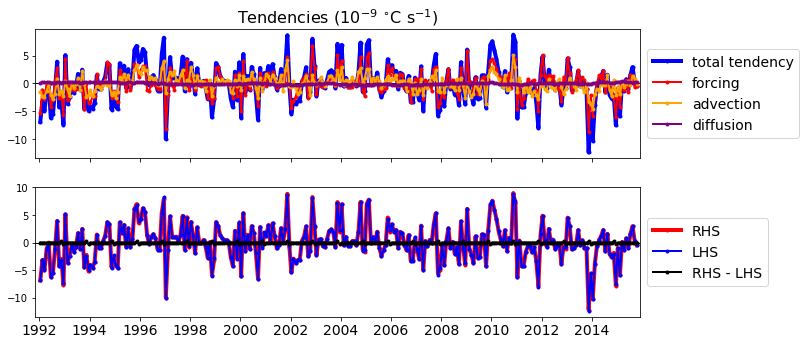

In [15]:
fig, axes = plt.subplots(2, 1,figsize=(12,5))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title(r'Tendencies (10$^{-9}$ $^{\circ}$C s$^{-1}$)',fontsize=16)

plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0]*1e9, lw=4, color='blue', marker='.',label='total tendency')
plt.plot(results[1].time, results[1]*1e9, lw=2, color='red', marker='.',label='forcing')
plt.plot(results[2].time, results[2]*1e9, lw=2, color='orange', marker='.',label='advection')
plt.plot(results[3].time, results[3]*1e9, lw=2, color='purple', marker='.',label='diffusion')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-10, 10])
#plt.yticks(np.arange(-3,4,1.0),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

plt.subplot(2, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[4].time, results[4]*1e9, lw=4, color='red', marker='.',label='RHS')
plt.plot(results[0].time, results[0]*1e9, lw=2, color='blue', marker='.',label='LHS')
plt.plot(results[0].time, (results[4]-results[0])*1e9, lw=2, color='k', marker='.',label='RHS - LHS')
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.ylim([-10, 10])
#plt.yticks(np.arange(-3,4,1.0),fontsize=14)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

fig.subplots_adjust(left=0.1, right=0.80, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Integrate over time
$$\int_t\frac{\partial\theta}{dt}dt = \int_t[-\nabla\cdot(\mathbf{u}\theta)]dt + \int_t-\nabla\cdot\mathbf{F_{diff}}dt + \int_t{F_{forc}}dt$$

In [16]:
H_tnd = (tendH_anom*coords_budg.dt).cumsum(dim='time')
H_frc = (forcH_anom*coords_budg.dt).cumsum(dim='time')
H_adv = (adv_ConvH_anom*coords_budg.dt).cumsum(dim='time')
H_dif = (dif_ConvH_anom*coords_budg.dt).cumsum(dim='time')
H_tot = (totalH_anom*coords_budg.dt).cumsum(dim='time')

In [17]:
results = dask.compute(H_tnd, H_frc, H_adv, H_dif, H_tot)

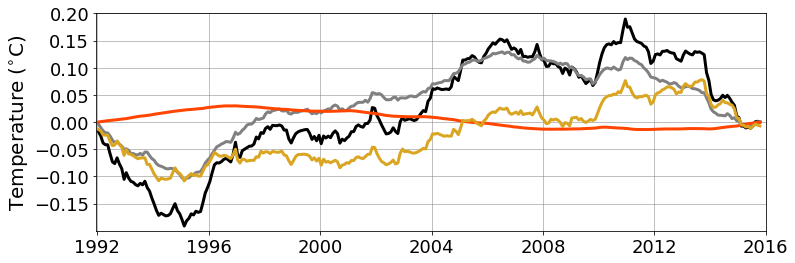

In [19]:
plt.figure(figsize=(12,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(results[0].time, results[0], lw=3, color='black',label='Total')
plt.plot(results[2].time, results[2], lw=3, color='grey',label='Advective heat convergence')
plt.plot(results[3].time, results[3], lw=3, color='orangered',label='Diffusive heat convergence')
plt.plot(results[1].time, results[1], lw=3, color='goldenrod',label='Forcing')

plt.xlim(['1992-01-15','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2020-01-15',freq='48M'),fontsize=18)
plt.ylim([-0.2, 0.2])
plt.yticks(np.arange(-0.15,0.25,0.05),fontsize=18)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=20)

#plt.savefig('/rigel/home/jt2796/figure.pdf')
#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Integrate over time and convert to heat content

In [20]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

In [21]:
H_tnd = (tendH_anom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_frc = (forcH_anom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_adv = (adv_ConvH_anom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_dif = (dif_ConvH_anom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_tot = (totalH_anom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])

In [22]:
results = dask.compute(H_tnd, H_frc, H_adv, H_dif, H_tot)

- $\mathcal{T}$: Total ocean heat content
- $\mathcal{A}$: Advective heat convergence
- $\mathcal{M}$: Diffusive heat convergence
- $\mathcal{F}$: Forcing

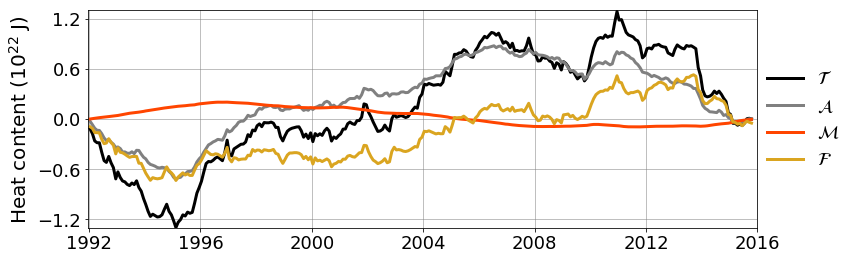

In [33]:
plt.figure(figsize=(12,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(results[0].time, results[0]*1e-22, lw=3, color='black',label=r'$\mathcal{T}$')
plt.plot(results[2].time, results[2]*1e-22, lw=3, color='grey',label=r'$\mathcal{A}$')
plt.plot(results[3].time, results[3]*1e-22, lw=3, color='orangered',label=r'$\mathcal{M}$')
plt.plot(results[1].time, results[1]*1e-22, lw=3, color='goldenrod',label=r'$\mathcal{F}$')

plt.xlim(['1992-01-15','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2020-01-15',freq='48M'),fontsize=18)
plt.ylim([-1.3, 1.3])
plt.yticks(np.arange(-1.2,1.8,0.6),fontsize=18)
plt.ylabel('Heat content (10$^{22}$ J)',fontsize=20)
plt.legend(loc='upper left',bbox_to_anchor=(0.99, 0.8),frameon=False,fontsize=18)

plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Decompose advection terms

In [34]:
Uanom_Tclim=(adv_ConvH_Uanom_Tclim*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
Uclim_Tanom=(adv_ConvH_Uclim_Tanom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
Uanom_Tanom=(adv_ConvH_Uanom_Tanom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])
H_res=(adv_ConvH_res_anom*coords_budg.dt).cumsum(dim='time')*c_p*rhoconst*vol.sum(dim=['face','k','j','i'])

In [35]:
results = dask.compute(H_adv, Uanom_Tclim, Uclim_Tanom, Uanom_Tanom, H_res)

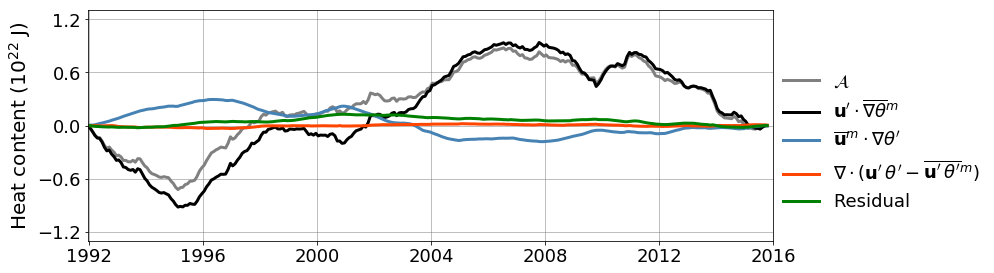

In [39]:
fig = plt.figure(figsize=(14,4))

plt.grid(linestyle='-', linewidth='0.5', color='grey')
plt.plot(results[0].time, results[0]*1e-22, lw=3, color='grey',label=r'$\mathcal{A}$')
plt.plot(results[1].time, results[1]*1e-22, lw=3, color='black',
         label=r'$\mathbf{u}^{\prime} \cdot \overline{\nabla\theta}^m$')
plt.plot(results[2].time, results[2]*1e-22, lw=3, color='steelblue',
         label=r'$\overline{\mathbf{u}}^m\cdot\nabla\theta^{\prime}$')
plt.plot(results[3].time, results[3]*1e-22, lw=3, color='orangered',
label=r'$\nabla \cdot ({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$')
plt.plot(results[4].time, results[4]*1e-22, lw=3, color='g',
         label=r'Residual')

plt.xlim(['1992-01-15','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2020-01-15',freq='48M'),fontsize=18)
plt.ylim([-1.3, 1.3])
plt.yticks(np.arange(-1.2,1.8,0.6),fontsize=18)
plt.ylabel('Heat content (10$^{22}$ J)',fontsize=20)
plt.legend(loc='upper left',bbox_to_anchor=(0.99, 0.8),frameon=False,fontsize=18)
fig.subplots_adjust(left=0.1, right=0.78, bottom=0.1, top=0.9)

plt.savefig('/rigel/home/jt2796/figure.pdf')
plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()